# UCCS Visualize

- read in all images, resized
- mean images
- read in all bboxes
- draw normalized bboxes

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils, im_utils
from app.models.bbox import BBox

In [30]:
fp_dir_uccs = '/data_store/datasets/people/uccs/dataset'
fp_dir_ims = '/data_store_ssd/datasets/people/uccs/media/original/'
fp_baseline = '/data_store/datasets/people/uccs/dataset/UCCS-v2-detection-baseline-validation.csv'
fp_out_bboxes = '/data_store/datasets/people/uccs/processed/uccs_bboxes_white_01.png'
fp_out_mean = '/data_store/datasets/people/uccs/processed/uccs_mean.png'

In [31]:
fp_ims = glob(join(fp_dir_ims, '*.jpg'))
print(len(fp_ims), 'images')

16149 images


In [33]:
im = cv.imread(fp_ims[0])
print(im.shape)

(3456, 5184, 3)


In [46]:
df_rois = pd.read_csv(fp_baseline)
roi_records = df_rois.to_dict('records')
df_rois.head()

FILE     BB_X     BB_Y  BB_WIDTH  \
0  000b35e2c91ccd4adb25e7e410db7b7c.jpg  3540.81  1973.13    237.21   
1  000b35e2c91ccd4adb25e7e410db7b7c.jpg  1576.59  2290.10    189.79   
2  000b35e2c91ccd4adb25e7e410db7b7c.jpg   706.63  1512.31    180.06   
3  000d7f5f2b753210388273e792dae92b.jpg  2106.86  2868.81    226.57   
4  000d7f5f2b753210388273e792dae92b.jpg   -17.83  1933.80    125.03   

   BB_HEIGHT  DETECTION_SCORE  
0     287.37             0.99  
1     223.13             0.97  
2     254.76             0.55  
3     279.73             1.00  
4     214.81             1.00

In [50]:
rois = {}
rois_all = []
dim = (5184, 3456)
for row in roi_records:
  x, y, w, h = row['BB_X'], row['BB_Y'], row['BB_WIDTH'], row['BB_HEIGHT']
  # threshold values for 5184x3456
  x = max(0, min(5184, x))
  y = max(0, min(y,3456))
  bbox = BBox.from_xywh_dim(x, y, w, h, dim)
  rois[row['FILE']] = bbox
  rois_all.append(bbox)

In [51]:
print(len(rois_all))

51838


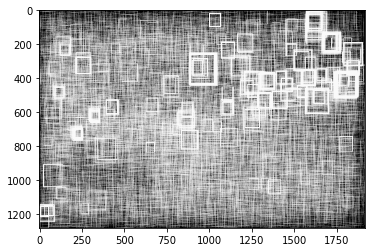

In [55]:
# draw it
clr = (255, 255, 255)
size_orig = (5184, 3456)
scale = size_orig[0]/1920
size_draw = (int(size_orig[0]/scale), int(size_orig[1]/scale))
im_draw = np.zeros([size_draw[1], size_draw[0], 3]).astype(np.uint8)
im_bg = im_draw.copy()
im[::] = (0,0,0)
limit = 2000000
stroke_weight = 1
alpha = 0.125

for i, bbox in enumerate(tqdm(rois_all)):
  bbox = bbox.to_dim(size_draw)
  pt1, pt2 = tuple(map(int, bbox.pt_tl)), tuple(map(int, bbox.pt_br))
  im_draw_next = im_bg.copy()
  cv.rectangle(im_draw_next, pt1, pt2, clr, stroke_weight, cv.LINE_AA)
  im_bg = cv.addWeighted(im_draw_next, alpha, im_bg, 1 - alpha, 0)
  if i > limit:
    break

cv.imwrite(fp_out_bboxes, im_bg)
plt.imshow(cv.cvtColor(im_bg, cv.COLOR_BGR2RGB))

## Create Average Image

In [38]:
#im_comp = np.empty_like(im_utils.resize(cv.imread(fp_im), width=1920) / 255)
im_comp = np.empty_like(cv.imread(fp_im) / 255)
for fp_im in tqdm(fp_ims):
  im = im_utils.resize(cv.imread(fp_im), width=1920) / 255
  im_comp += im

In [39]:
im_mean = np.mean(ims, axis=0).astype(np.uint8)

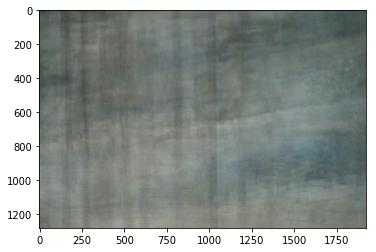

In [40]:
plt.imshow(im_mean)

In [41]:
cv.imwrite(fp_out_mean, im_mean)

True